In [51]:
using AvailablePotentialEnergyFramework, PyPlot, NCDatasets, Statistics, PyCall

In [3]:
data_dir = "$(ENV["SCRATCH"])/for_postprocessing/largencfiles/"

"/global/cscratch1/sd/aramreye/for_postprocessing/largencfiles/"

In [4]:
function compute_ape(data_dir,experiment)
    initial_timeindex = 1140
    final_timeindex = 1200
    day           = 86400
    sst           = 300
    dt            = 7200
    dayLength     = 60*60*24÷7200; #How many data points make one day
    Pref          = 1000*1f2                 #Pa
    Ts            = sst                      #Sea surface temperature
    qs            = 25.7*1f-3 
    Tvs           = Ts*(1+Float32(epsilon)*qs)
    c1            = Float32((Dryair.R/Dryair.cp))
    file2d = joinpath(data_dir,"f5e-4_2km_1000km_$(experiment)_2d.nc")
    file3d = joinpath(data_dir,"f5e-4_2km_1000km_$(experiment)_3d.nc")
    iterator_time_2d    = initial_timeindex*2:2:final_timeindex*2  
    iterator_time_3d    = initial_timeindex:1:final_timeindex
    iterator_z = 1:60
    ds3d                = Dataset(file3d)
    ds2d                = Dataset(file2d)
    x                   = variable(ds3d,"x")[:]    :: Array{Float32,1}
    y                   = variable(ds3d,"y")[:]    :: Array{Float32,1}
    z                   = variable(ds3d,"z")[iterator_z]    :: Array{Float32,1}
    t                   = variable(ds3d,"time")[iterator_time_3d] :: Array{Float32,1}
    P0                  = variable(ds3d,"p")[iterator_z]    :: Array{Float32,1}
    RAD                 = variable(ds3d,"QRAD")[:,:,iterator_z,iterator_time_3d] :: Array{Float32,4}
    T                   = variable(ds3d,"TABS")[:,:,iterator_z,iterator_time_3d] :: Array{Float32,4}
    Tv                  = variable(ds3d,"QV")[:,:,iterator_z,iterator_time_3d] :: Array{Float32,4}
    PP                  = variable(ds3d,"PP")[:,:,iterator_z,iterator_time_3d] :: Array{Float32,4}
    SHF                 = variable(ds2d,"SHF")[:,:,iterator_time_2d] :: Array{Float32,3}            
    LHF                 = variable(ds2d,"LHF")[:,:,iterator_time_2d] :: Array{Float32,3}
    @info "Finished reading%"
    close(ds2d)
    close(ds3d)

    @. SHF    =Float32(g/(1*Dryair.cp*Ts))*(SHF)                            
    @. LHF    = Float32(g/(1*Dryair.cp*Ts))*(Float32(epsilon*Dryair.cp*Ts)/Float32(Liquidwater.Lv)*LHF) 
    @. SHF    +=  LHF     # Now it is transformed 
    ThetaV       = similar(T)
    xBar_Pt      = Array{eltype(T),4}(undef,1,1,size(PP,3),size(PP,4))
    xBar_Tv      = Array{eltype(T),4}(undef,1,1,size(Tv,3),size(Tv,4))
    xBar_ThetaV  = Array{eltype(T),4}(undef,1,1,size(ThetaV,3),size(ThetaV,4));

    dx           = x[2]-x[1]
    dy           = y[2]-y[1]                            # Grid size
    kz           = length(z)                            # vertical levels
    kx           = length(x)                            # # of horizonal grid points
    ky           = length(y)                            # # of horizonal grid points
    @.  RAD      = RAD/day                              # K/s #Heating rate per second
    @.  Tv       = (1 + 1f-3*Float32(epsilon)*Tv)*T  
    T          = []# Virtual temperature
    @.  P0       = P0*1f2
    PP          .= PP .+ reshape(P0,(1,1,kz,1))
    ThetaV      .= Tv.*(P0[1]./PP).^c1 # Virtual potential temp
    mean!(xBar_Pt,PP)                                     
    mean!(xBar_Tv,Tv)              
    mean!(xBar_ThetaV,ThetaV)   
    var_Tv       =  Tv     .- xBar_Tv
    var_ThetaV   =  ThetaV .- xBar_ThetaV
    rho0         = dropdims(xBar_Pt./Float32(R)./xBar_Tv,dims=(1,2))
    B            = Float32(g) .* var_ThetaV./xBar_ThetaV                  # convert unit to buoyancy
    PP           = []
    U = V = W = RAD = Diabatic_other = zeros(Float32,size(ThetaV));
    N2           = compute_N2(xBar_Tv,z);
    LHF        = []
    ThetaV     = []
    Tv         = []
    var_ThetaV = []
    var_Tv     = []
    xBar_Tv    = []
    GC.gc()
    return (getapebudget(B, U,V, W, N2, RAD, SHF, Diabatic_other, rho0, x,y, z, t, dx,dy, 50, dt, 15000)...,N2,B,rho0)
end

compute_ape (generic function with 1 method)

In [5]:
(int_mass_control,int_KE_control,int_APE_control,int_APE_rate_control,int_APE_Ub2_control,
    int_APE_Vb2_control,int_APE_WN2_control,int_APE_RAD_control,int_APE_DIA_control,    
       xBar_APE_Fs_control,residual_control,N2_control,B_control,rho0_control) = compute_ape(data_dir,"control")
GC.gc()

┌ Info: Finished reading%
└ @ Main In[4]:31
┌ Info: Sizes: 
│   size(B) = (512, 512, 60, 61)
│   size(N2) = (1, 1, 60, 61)
│   size(Fs) = (512, 512, 61)
└ @ AvailablePotentialEnergyFramework /global/homes/a/aramreye/.julia/dev/AvailablePotentialEnergyFramework/src/apebudgets.jl:305
┌ Info: (1, 1, 61)
└ @ AvailablePotentialEnergyFramework /global/homes/a/aramreye/.julia/dev/AvailablePotentialEnergyFramework/src/apebudgets.jl:306


In [6]:
GC.gc()

In [7]:
(int_mass_homoRad,int_KE_homoRad,int_APE_homoRad,int_APE_rate_homoRad,int_APE_Ub2_homoRad,
    int_APE_Vb_homoRad2,int_APE_WN2_homoRad,int_APE_RAD_homoRad,int_APE_DIA_homoRad,    
       xBar_APE_Fs_homoRad,residual_homoRad,N2_homoRad,B_homoRad,rho0_homoRad) = compute_ape(data_dir,"homoRad")
GC.gc()

┌ Info: Finished reading%
└ @ Main In[4]:31
┌ Info: Sizes: 
│   size(B) = (512, 512, 60, 61)
│   size(N2) = (1, 1, 60, 61)
│   size(Fs) = (512, 512, 61)
└ @ AvailablePotentialEnergyFramework /global/homes/a/aramreye/.julia/dev/AvailablePotentialEnergyFramework/src/apebudgets.jl:305
┌ Info: (1, 1, 61)
└ @ AvailablePotentialEnergyFramework /global/homes/a/aramreye/.julia/dev/AvailablePotentialEnergyFramework/src/apebudgets.jl:306


In [ ]:
(int_mass_homoSfc,int_KE_homoSfc,int_APE_homoSfc, int_APE_rate_homoSfc,int_APE_Ub2_homoSfc,
    int_APE_Vb2_homoSfc,int_APE_WN2_homoSfc,int_APE_RAD_homoSfc,int_APE_DIA_homoSfc,    
       xBar_APE_Fs_homoSfc,residual_homoSfc,N2_homoSfc,B_homoSfc,rho0_homoSfc) = compute_ape(data_dir,"homoSfc")
GC.gc()

In [8]:
 (int_mass_homoRad_homoSfc,int_KE_homoRad_homoSfc,int_APE_homoRad_homoSfc, int_APE_rate_homoRad_homoSfc,int_APE_Ub2_homoRad_homoSfc,
     int_APE_Vb2_homoRad_homoSfc,int_APE_WN2_homoRad_homoSfc,int_APE_RAD_homoRad_homoSfc,int_APE_DIA_homoRad_homoSfc,    
        xBar_APE_Fs_homoRad_homoSfc,residual_homoRad_homoSfc,N2_homoRad_homoSfc,B_homoRad_homoSfc,rho0_homoRad_homoSfc) = compute_ape(data_dir,"homoRad_homoSfc")

┌ Info: Finished reading%
└ @ Main In[4]:31
┌ Info: Sizes: 
│   size(B) = (512, 512, 60, 61)
│   size(N2) = (1, 1, 60, 61)
│   size(Fs) = (512, 512, 61)
└ @ AvailablePotentialEnergyFramework /global/homes/a/aramreye/.julia/dev/AvailablePotentialEnergyFramework/src/apebudgets.jl:305
┌ Info: (1, 1, 61)
└ @ AvailablePotentialEnergyFramework /global/homes/a/aramreye/.julia/dev/AvailablePotentialEnergyFramework/src/apebudgets.jl:306


(Float32[8846.205, 8845.979, 8845.949, 8845.642, 8845.644, 8845.562, 8845.335, 8844.816, 8844.544, 8844.112  …  8838.476, 8838.428, 8838.713, 8838.867, 8838.86, 8839.114, 8839.734, 8840.1455, 8840.168, 8839.901], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[218267.38, 210864.64, 195789.3, 189937.98, 212200.19, 204289.25, 197006.48, 206579.42, 222113.42, 223627.88  …  231080.2, 227762.02, 154467.61, 188239.75, 194553.47, 277499.0, 222460.44, 173042.95, 215199.88, 213499.56], Float32[-1.0278908, -2.093507, -0.8121643, 3.0927863, -1.0990627, -1.0104263, 1.3319844, 2.1588018, 0.21294919, 0.08375042  …  -0.45996755, -10.180026, 4.6894135, 0.87732005, 11.518995, -7.647163, -6.865507, 5.853855, -0.2358368, -0.23588234], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

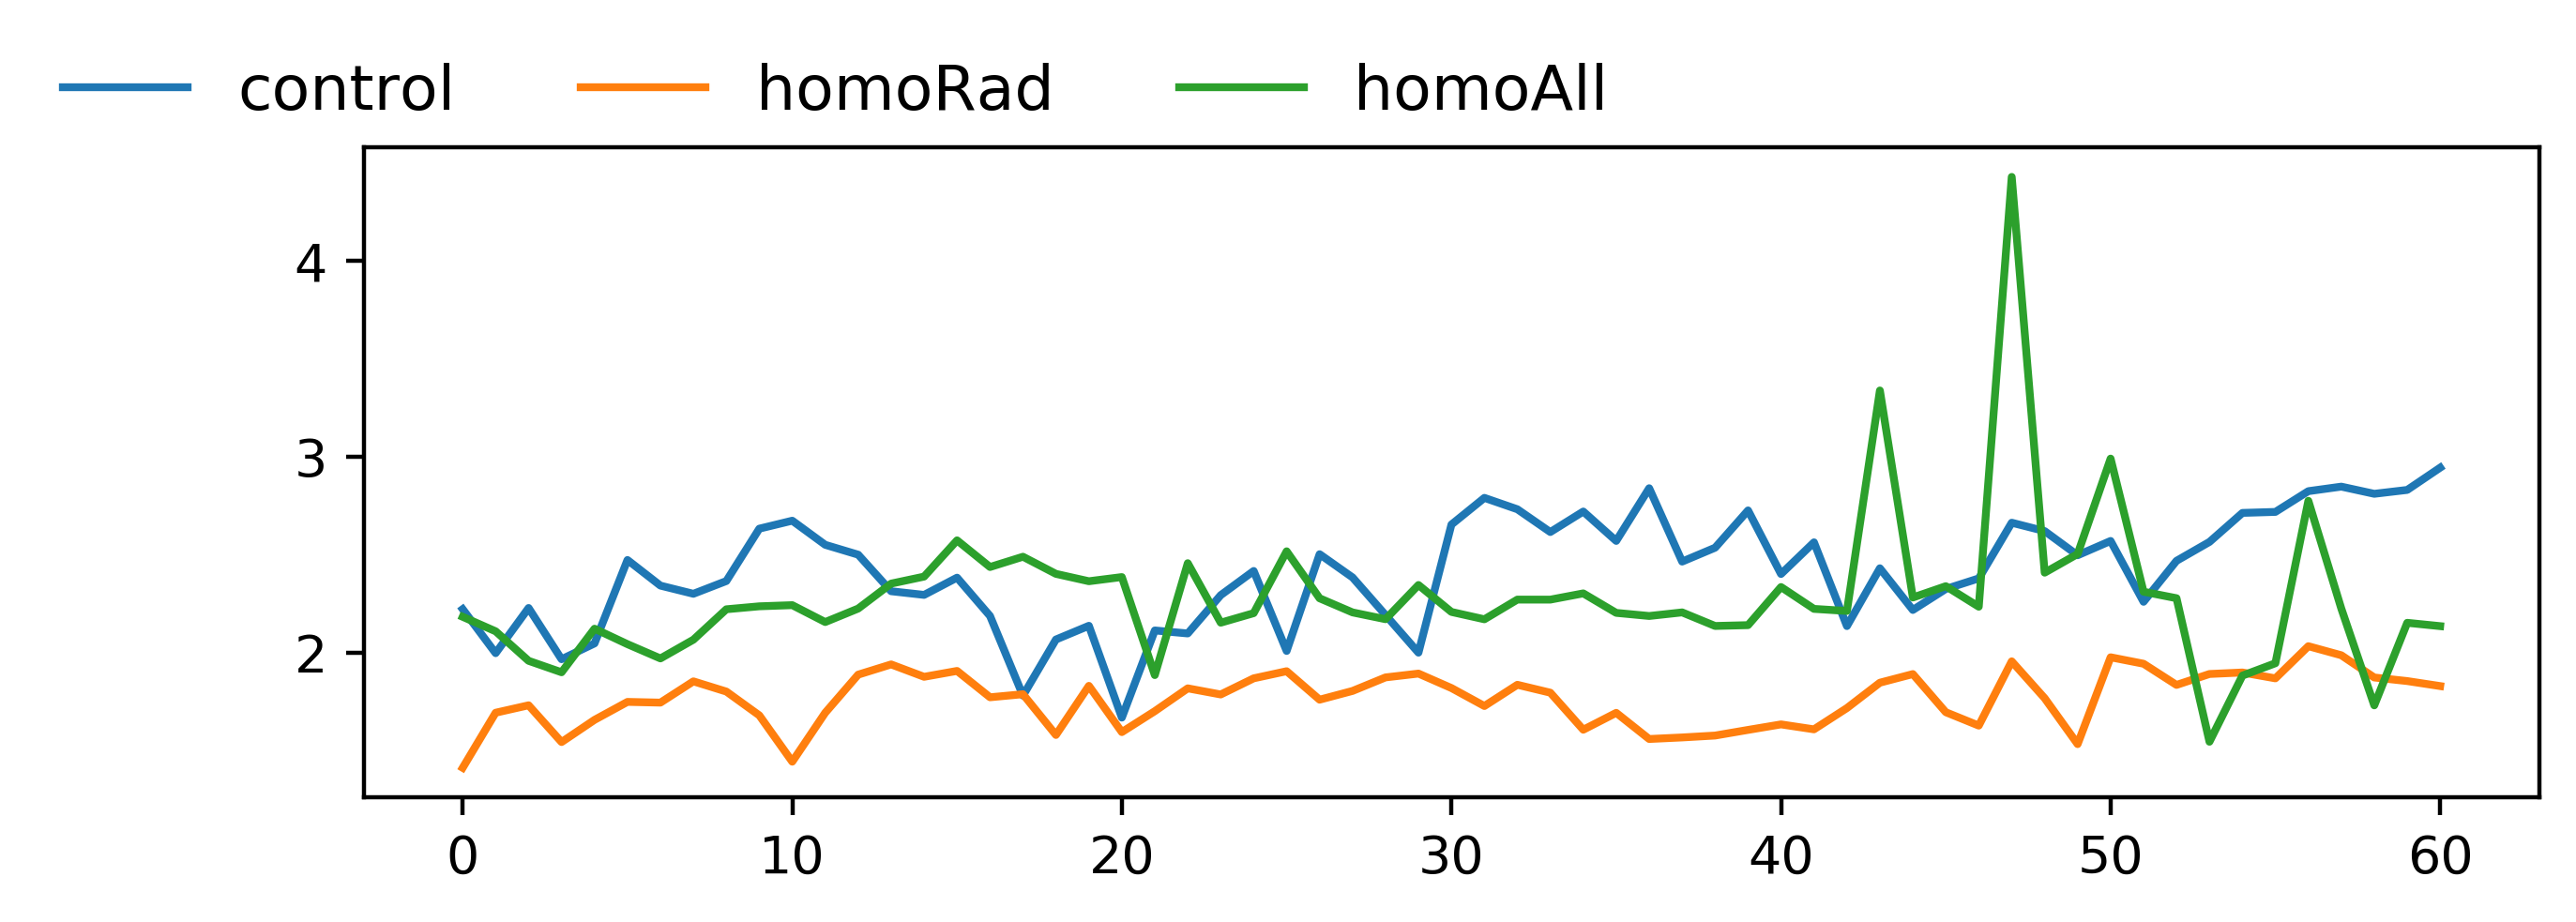

PyObject <matplotlib.legend.Legend object at 0x2aab07c92f10>

In [16]:
fig, ax = plt.subplots(1,sharex=true,figsize=(2*3.74,0.5*4.5),dpi=400)
ax.plot(1e-5int_APE_control,label="control")
ax.plot(1e-5int_APE_homoRad,label="homoRad")
ax.plot(1e-5int_APE_homoRad_homoSfc,label="homoAll")
ax.legend(loc = (-0.15, 1), ncol=4 ,frameon=false,fontsize=12)

In [68]:
z_grd = 1f-3 .* [50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1178.57142857143 1385.71428571429 1671.42857142857 2035.71428571429 2478.57142857143 3000 3600 4200 4800 5400 6000 6600 7200 7800 8400 9000 9600 10200 10800 11400 12000 12600 13200 13800 14400 15000 15600 16200 16800 17400 18000 18600 19200 19800 20400 21000 21600 22200 22800 23400 24000 24600 25200 25800 26400 27000 27600 28200 28800 29400 30000 30600 31200 31800 32400 33000 33600 34200 34800][1:60];

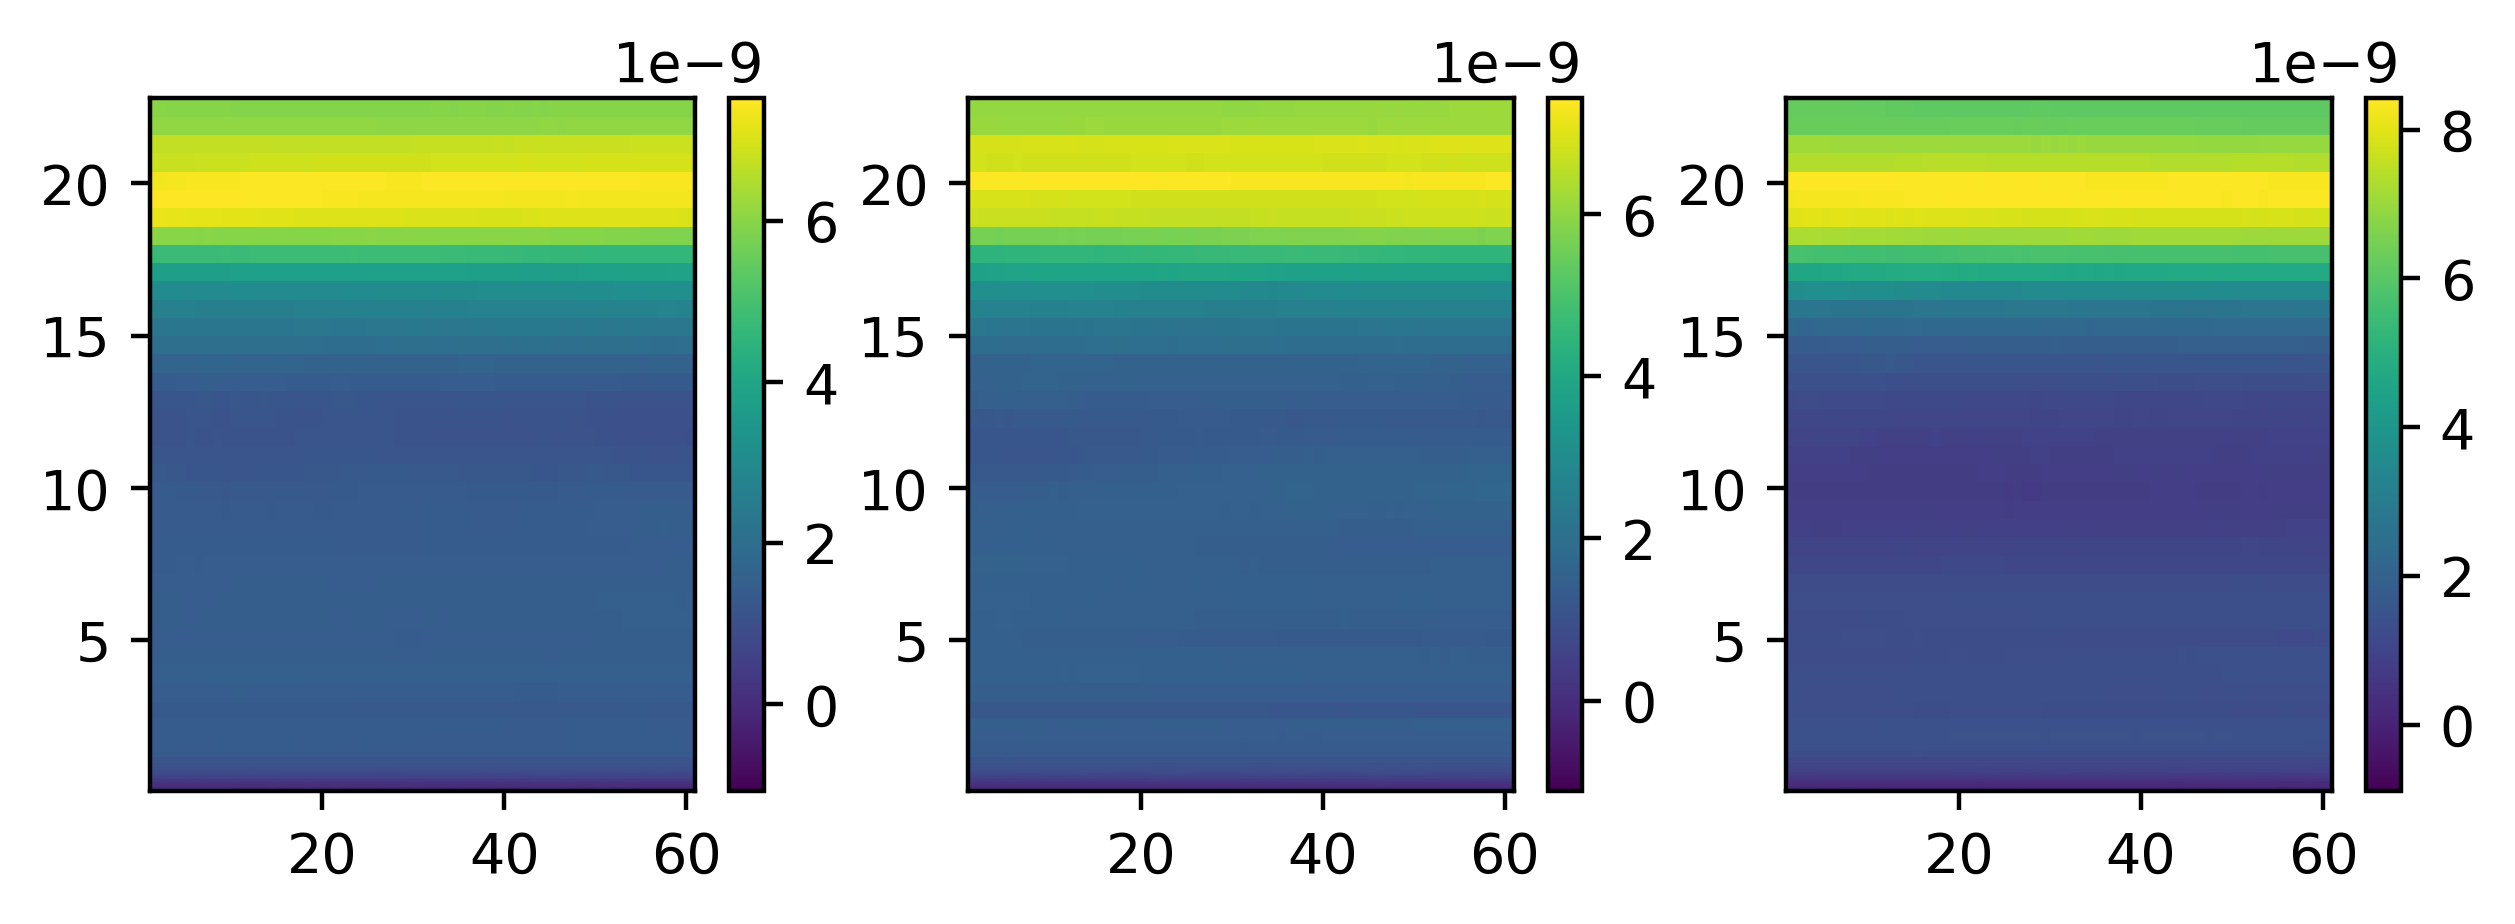

PyObject <matplotlib.colorbar.Colorbar object at 0x2aadd9d98c90>

In [93]:
fig, ax = plt.subplots(1,3,figsize=(2*3.74,0.5*4.5),dpi=400)
p1 = ax[1].pcolor(collect(1:61),z_grd,1e-5N2_control,label="control")
p2 = ax[2].pcolor(collect(1:61),z_grd,1e-5N2_homoRad,label="homoRad")
p3 = ax[3].pcolor(collect(1:61),z_grd,1e-5N2_homoRad_homoSfc,label="homoAll")
fig.colorbar(p1, ax=ax[1])
fig.colorbar(p2, ax=ax[2])
fig.colorbar(p3, ax=ax[3])

In [30]:
B2_control = B_control.*B_control
B2_homoRad = B_homoRad.*B_homoRad
B2_homoRad_homoSfc = B_homoRad_homoSfc.*B_homoRad_homoSfc;

512×512×60×61 Array{Float32,4}:
[:, :, 1, 1] =
 0.000243733  0.000351651  0.00023146   …  0.000273199  0.000208597
 3.69695f-5   0.000423406  0.000195835     0.00052672   0.000270927
 0.000118618  0.000142338  0.0004642       8.65031f-5   0.00017765
 0.00010951   0.00037466   0.00012809      3.85254f-5   1.13322f-5
 0.000371373  0.00111481   0.000834739     2.37039f-5   2.53492f-5
 0.000422323  0.000379854  0.00029058   …  8.22049f-7   1.18155f-6
 0.00012386   0.000645773  0.000117891     0.000176491  3.56631f-5
 4.0229f-5    0.000152972  3.54939f-5      0.000454819  9.65397f-5
 0.000119968  0.000415605  1.53938f-5      0.000729849  0.000218665
 6.36757f-5   9.84401f-5   2.77367f-6      0.00099183   0.000314109
 7.88776f-5   0.00027253   7.09305f-6   …  0.00243704   0.000590773
 8.97938f-5   5.67454f-5   6.148f-7        0.00385116   0.00154074
 2.11327f-6   0.000127723  5.8081f-5       0.00292312   0.00110765
 ⋮                                      ⋱  ⋮            
 0.000501547  0.0006

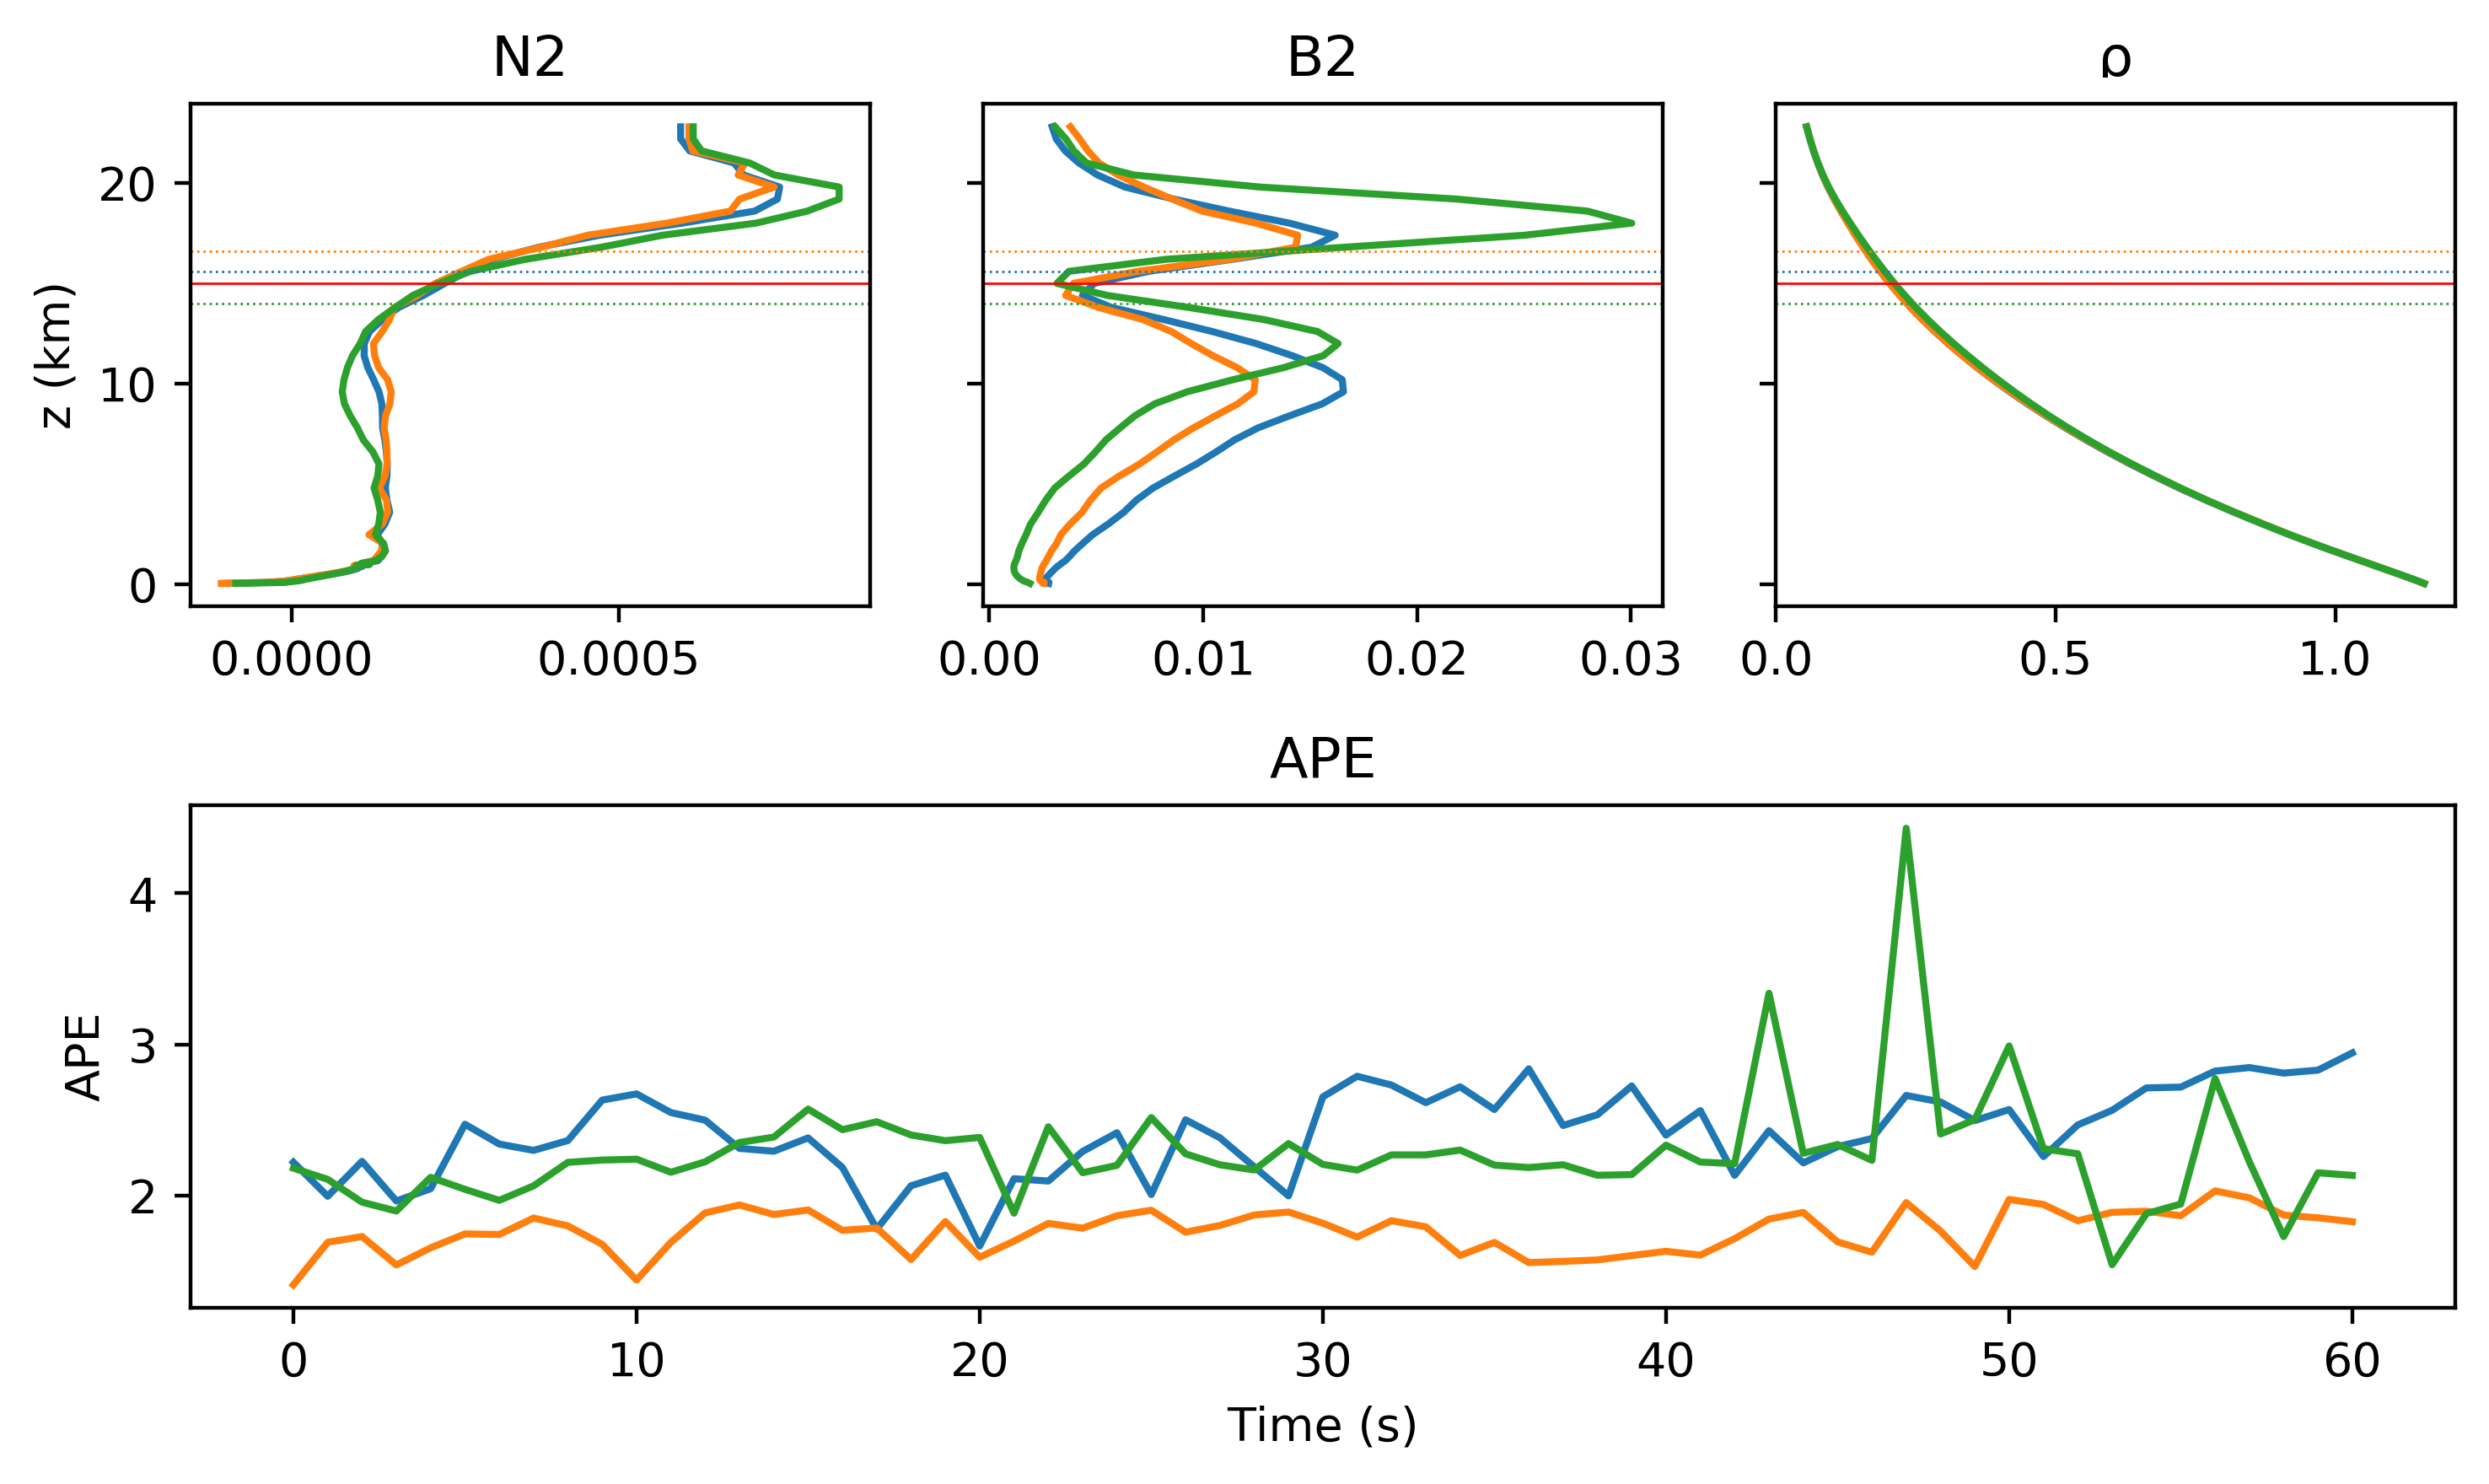

In [91]:
fig = figure(figsize=(2*3.74,4.5),dpi=400)
gs = fig.add_gridspec(2,3)

element(i,j) = get(gs, (i,j))
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j)

ax1 = fig.add_subplot(element(0,0))
ax2 = fig.add_subplot(element(0,1))
ax3 = fig.add_subplot(element(0,2))
ax4 = fig.add_subplot(element(1,slice(0,3)))
ax2.set_yticklabels([])
ax3.set_yticklabels([])


ax1.set_title("N2")
ax2.set_title("B2")
ax3.set_title("ρ")
ax4.set_title("APE")
ax1.set_ylabel(string("z (km)"))
ax4.set_ylabel(string("APE"))
ax4.set_xlabel(string("Time (s)"))

ax1.plot(mean(N2_control,dims=2),z_grd,label="control")
ax1.plot(mean(N2_homoRad,dims=2),z_grd,label="homoRad")
ax1.plot(mean(N2_homoRad_homoSfc,dims=2),z_grd,label="homoAll")

ax2.plot(dropdims(mean(B2_control,dims=(1,2,4)),dims=(1,2,4)),z_grd,label="control")
ax2.plot(dropdims(mean(B2_homoRad,dims=(1,2,4)),dims=(1,2,4)),z_grd,label="homoRad")
ax2.plot(dropdims(mean(B2_homoRad_homoSfc,dims=(1,2,4)),dims=(1,2,4)),z_grd,label="homoAll")

ax3.plot(mean(rho0_control,dims=2),z_grd,label="control")
ax3.plot(mean(rho0_homoRad,dims=2),z_grd,label="homoRad")
ax3.plot(mean(rho0_homoRad_homoSfc,dims=2),z_grd,label="homoAll")

ax4.plot(1e-5int_APE_control,label="control")
ax4.plot(1e-5int_APE_homoRad,label="homoRad")
ax4.plot(1e-5int_APE_homoRad_homoSfc,label="homoAll")

ax1.axhline(y=15, color="r", linestyle="-",linewidth = 0.5)
ax2.axhline(y=15, color="r", linestyle="-",linewidth = 0.5)
ax3.axhline(y=15, color="r", linestyle="-",linewidth = 0.5)

ax1.axhline(y=15.6, color="C0", linestyle=":",linewidth = 0.5)
ax1.axhline(y=16.6, color="C1", linestyle=":",linewidth = 0.5)
ax1.axhline(y=14, color="C2", linestyle=":",linewidth = 0.5)

ax2.axhline(y=15.6, color="C0", linestyle=":",linewidth = 0.5)
ax2.axhline(y=16.6, color="C1", linestyle=":",linewidth = 0.5)
ax2.axhline(y=14, color="C2", linestyle=":",linewidth = 0.5)

ax3.axhline(y=15.6, color="C0", linestyle=":",linewidth = 0.5)
ax3.axhline(y=16.6, color="C1", linestyle=":",linewidth = 0.5)
ax3.axhline(y=14, color="C2", linestyle=":",linewidth = 0.5)


plt.tight_layout()